## Arnoldi method

The Arnoldi method is an extension on the power method. For a matrix in $\mathbb{R}^{n, n}$, it computes a set of $k$ largest eigenvalues

It improves on the power method in the following ways:

1. it computes multiple eigenpairs at once
2. it builds an orthonormal basis $Q$ of the Krylov space $\text{span}\{x, Ax, A^2x, \ldots, A^{k-1}x\}$.
3. it builds a partial Hessenberg decomposition of $A$

### Properties

In practice, it iteratively builds the Arnoldi decomposition. For iteration $m$, this is $$AQ = QH + h_{m+1,m}q_{m+1}e_m^T$$

where $e_m$ is the m-th unit vector in $\mathbb{R}^n$.

This decomposition has the following properties:

1. It projects $A$ onto the Krylov subspace: $Q^T AQ = \bar{H}$ ($m \times m$ matrix, $\bar{H}$ is $H$ without its last row)
2. It compute ritz pairs: if $(\theta, y)$ is an eigenpair of $\bar{H}$, then $(\theta, Qy)$ is an approximate eigenpair of $A$.
3. Residuals can be computed to check convergence. For an approximate eigenpair $(\theta, x = Qy)$: $r = Ax - \theta x = (AQ - Q\bar{H})y = h_{m+1,m}(e_m^T y)q_{m+1}$

In [1]:
import os.path as op

import numpy as np
from scipy.io import loadmat
from scipy.linalg import eig, eigvals, qr
from scipy.sparse.linalg import eigs as s_eigs

import matplotlib.pyplot as plt

import seaborn as sns
sns.set_theme()

In [2]:
def load_data(name):
    d = loadmat(f"{name}.mat")
    A = d["Problem"][0][0][1]
    d = loadmat(f"{name}_SVD.mat")
    v = d["S"][0][0][0]

    return A, v[:, 0]

# From the suite sparse matrix collection
A, A_v_ref = load_data(op.join("data", "1138_bus"))

In [3]:
def arnoldi(A, q, m, tol=1e-7):
    """ Arnoldi methods for square matrix A.

    Parameters
    ----------
    A: 2d n x n array
    q: initial 1d n array (generally randomly generated)
    m: integer
    """
    # This simple arnoldi implementation builds 
    # 1. an orthonormal basis Q of the Krylov space for A
    # 2. an Hessenberg transform of A
    assert A.ndim == 2
    assert v.ndim == 1
    assert A.shape[0] == A.shape[1], "A is not square"

    n = A.shape[0]
    # Q is the orthonormal basis of A's Krylov space
    Q = np.zeros((n, m+1), A.dtype)
    # H will be the Hessenberg matrix
    H = np.zeros((m+1, m), A.dtype)

    Q[:, 0] = q / np.linalg.norm(q)

    for j in range(m):
        w = A @ Q[:, j]
        for i in range(j):
            H[i, j] = Q[:, i] @ w
            # Orthogonalization step
            w = w - H[i, j] * Q[:, i]

        H[j+1, j] = np.linalg.norm(w)
        if np.abs(H[j+1, j]) < tol:
            print(f"Lucky breakdown @ {j}!")
            return Q[:, :j+1], H[:j+1, :j+1]

        Q[:, j+1] = w / H[j+1, j]

    return Q[:, :m], H[:m, :]

def compute_residuals(A, Q, H, m):
    eigenvalues, eigenvectors = np.linalg.eig(H)
    residuals = np.zeros(m, dtype=A.dtype)
    for i, (λ, v) in enumerate(zip(eigenvalues[:m], eigenvectors[:, :m].T)):
        Qv = Q @ v
        r = A @ Qv - λ * Qv
        residuals[i] = np.linalg.norm(r)

    return residuals

In [9]:
n_iter = 100
n_eigs = 10
v = np.random.randn(A.shape[0])
V, H = arnoldi(A, v, n_iter)
A_v_arpack = s_eigs(A, n_eigs)[0]

residuals = compute_residuals(A, V, H, n_iter)

ref = A_v_ref[:n_eigs]

# Hack to make eigenvalues comparable. Reference and "proper" eigensolvers will
# give the eigenvalues in (decreasing) sorted order
A_v = eigvals(H)
idx = np.argsort(A_v)[::-1]
A_v_arnoldi = A_v[idx][:n_eigs]
residuals = residuals[idx]

for j in range(n_eigs):
    print(f"diff arnoldi vs ref:         {np.linalg.norm(A_v_arnoldi[j] - ref[j])}")
for j in range(n_eigs):
    print(f"residual {j} is:               {residuals[j]}")

diff arnoldi vs ref:         7.639755494892597e-11
diff arnoldi vs ref:         5.093170329928398e-11
diff arnoldi vs ref:         5.4569682106375694e-11
diff arnoldi vs ref:         2.9103830456733704e-11
diff arnoldi vs ref:         4.3655745685100555e-11
diff arnoldi vs ref:         5.893525667488575e-09
diff arnoldi vs ref:         7.101334631443024e-09
diff arnoldi vs ref:         8.72751115821302e-08
diff arnoldi vs ref:         7.392372936010361e-09
diff arnoldi vs ref:         2.6666384655982256e-09
residual 0 is:               5.328075981505861e-11
residual 1 is:               7.533550863877116e-11
residual 2 is:               6.73797501759704e-11
residual 3 is:               4.1700410330979675e-11
residual 4 is:               8.652502324976372e-11
residual 5 is:               1.171473860868729e-05
residual 6 is:               2.8434280657651784e-05
residual 7 is:               0.00018449240539092506
residual 8 is:               3.3981243216594365e-05
residual 9 is:           

Text(0.5, 1.0, 'Residuals')

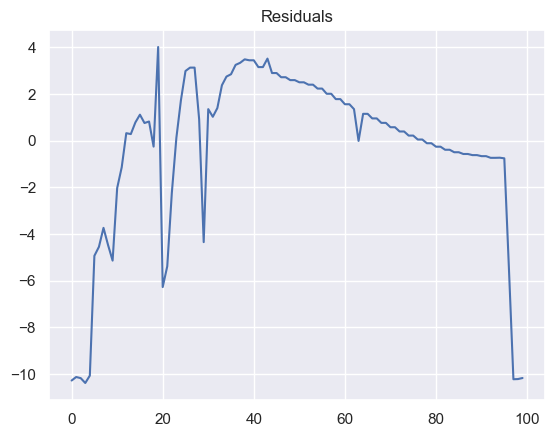

In [10]:
plt.plot(np.log10(residuals))
plt.title("Residuals")

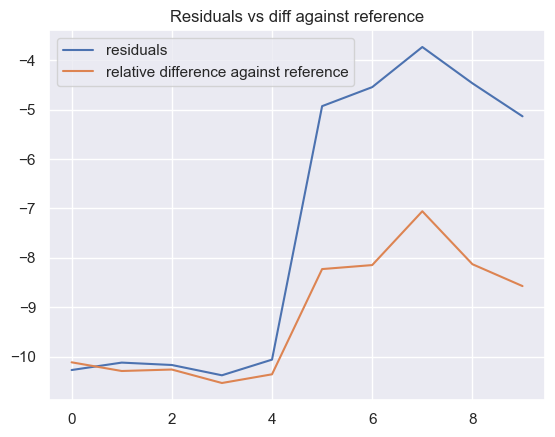

In [11]:
ref_diff = np.array([np.linalg.norm(A_v_arnoldi[j] - ref[j]) for j in range(n_eigs)])
plt.plot(np.log10(residuals[:n_eigs]), label="residuals")
plt.plot(np.log10(ref_diff), label="relative difference against reference")
plt.title("Residuals vs diff against reference")
plt.legend()

In [32]:
def explicitly_restarted_arnoldi(A, v0, m, k, max_restarts, tol=1e-7):
    """
    Explicitely restarted Arnoldi

    Parameters
    ----------
    A: 2d array
        The matrix to compute eigenvalue
    v0: array
        initial vector
    m: int
        working size for Arnoldi iteration, aka the size of the Krylov subspace.
    k: int
        number of desired eigenvalues
    max_restarts: int
        maximum number of restarts
    tol: float
        convergence tolerance
    """
    n = len(v0)
    v0 = v0 / np.linalg.norm(v0)
    
    for restart in range(max_restarts):
        Q, H = arnoldi(A, v0, m, tol)
        
        eigenvalues, eigenvectors = np.linalg.eig(H)
        
        idx = np.argsort(eigenvalues)[::-1]
        eigenvalues = eigenvalues[idx]
        eigenvectors = eigenvectors[:, idx]
        
        if check_convergence(A, Q, eigenvalues[:k], eigenvectors[:, :k], tol):
            print(f"Did {restart} restarts")
            return eigenvalues[:k], Q @ eigenvectors[:, :k]
        
        # If not converged, compute new starting vector and restart
        v0 = compute_new_start_vector(Q, eigenvectors, k)
    
    print("""\x1b[31m!!!!!!! WARNING !!!!!\x1b[0m: Max restarts reached without convergence""")
    return eigenvalues[:k], Q @ eigenvectors[:, :k]


def check_convergence(A, Q, eigenvalues, eigenvectors, tol):
    for i in range(len(eigenvalues)):
        λ = eigenvalues[i]
        v = Q @ eigenvectors[:, i]
        r = A @ v - λ * v
        if np.linalg.norm(r) >= tol:
            return False
    return True

def compute_new_start_vector(Q, eigenvectors, k):
    # Compute a linear combination of the k desired Ritz vectors
    v = Q @ eigenvectors[:, :k] @ np.random.rand(k)
    return v / np.linalg.norm(v)

In [65]:
n_eigs = 10
m = 70
max_restarts = m
00

n = A.shape[0]
v0 = np.random.randn(n)
A_v_restarted_arnoldi, _ = explicitly_restarted_arnoldi(A, v0, m, n_eigs, max_restarts)

for j in range(n_eigs):
    print(f"diff arnoldi vs ref:         {np.linalg.norm(A_v_restarted_arnoldi[j] - ref[j])}")
#for j in range(n_eigs):
#    print(f"residual {j} is:               {residuals[j]}")

print(ref)
print(A_v_restarted_arnoldi)

Did 10 restarts
diff arnoldi vs ref:         1.673470251262188e-10
diff arnoldi vs ref:         6.548361852765083e-11
diff arnoldi vs ref:         9.822542779147625e-11
diff arnoldi vs ref:         7.275957614183426e-12
diff arnoldi vs ref:         8.36735125631094e-11
diff arnoldi vs ref:         1.6952981241047382e-09
diff arnoldi vs ref:         4.0236045606434345e-09
diff arnoldi vs ref:         2.8339854907244444e-09
diff arnoldi vs ref:         1.5788828022778034e-09
diff arnoldi vs ref:         1.0550138540565968e-10
[30148.79442195 30010.49003665 30001.30387136 21947.83632803
 21051.05114749 20522.45889281 20508.06949329 20491.41298469
 20475.89917738 20344.48305842]
[30148.79442195+0.j 30010.49003665+0.j 30001.30387136+0.j
 21947.83632803+0.j 21051.05114749+0.j 20522.45889281+0.j
 20508.06949329+0.j 20491.41298469+0.j 20475.89917738+0.j
 20344.48305842+0.j]


/var/folders/01/9vwc046112d_v9626qkq4cr00000gr/T/ipykernel_5161/1384267772.py:23: ComplexWarning: Casting complex values to real discards the imaginary part
  Q[:, 0] = q / np.linalg.norm(q)
